# Progetto di Data Mining 2.5 Clustering

## Pendigits Dataset Analysis and Processing

Importiamo le librerie che andremo ad utilizzare

In [1]:
#import Librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_openml

Scarichiamo il Dataset

   x0   y0  x1   y1   x2   y2   x3   y3  x4  y4   x5  y5   x6  y6   x7  y7  \
0  47  100  27   81   57   37   26    0   0  23   56  53  100  90   40  98   
1   0   89  27  100   42   75   29   45  15  15   37   0   69   2  100   6   
2   0   57  31   68   72   90  100  100  76  75   50  51   28  25   16   0   
3   0  100   7   92    5   68   19   45  86  34  100  45   74  23   67   0   
4   0   67  49   83  100  100   81   80  60  60   40  40   33  20   47   0   

  target  
0      8  
1      2  
2      1  
3      4  
4      1  


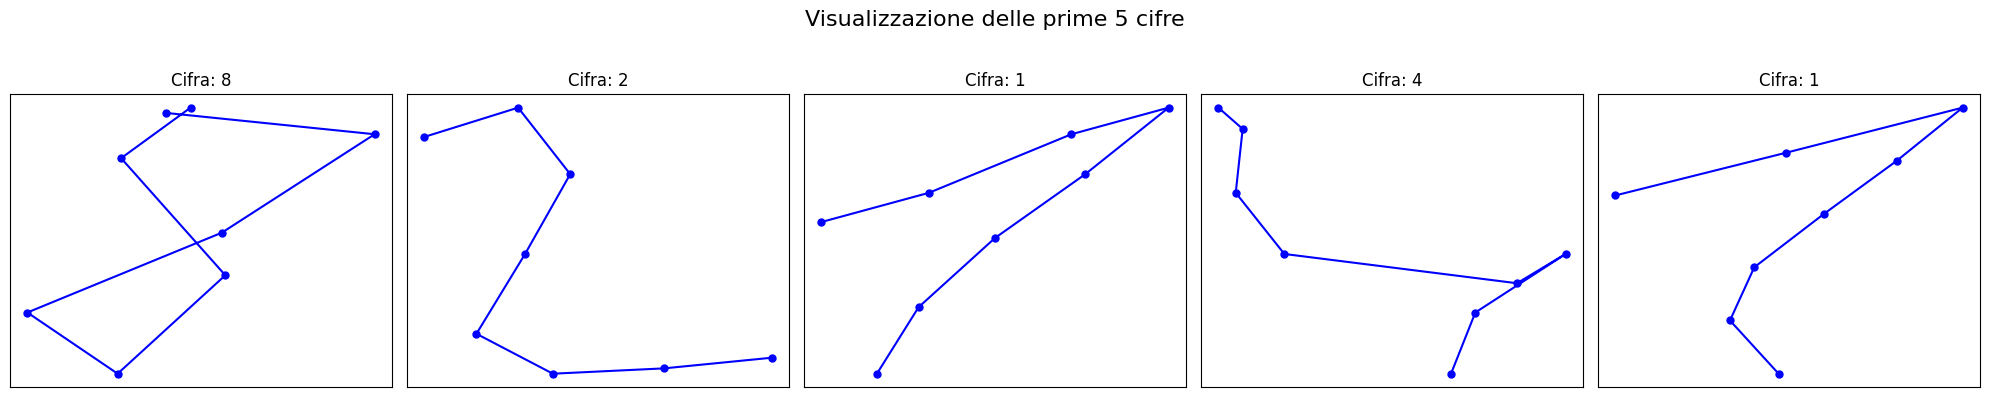

Il dataset non contiene valori mancanti


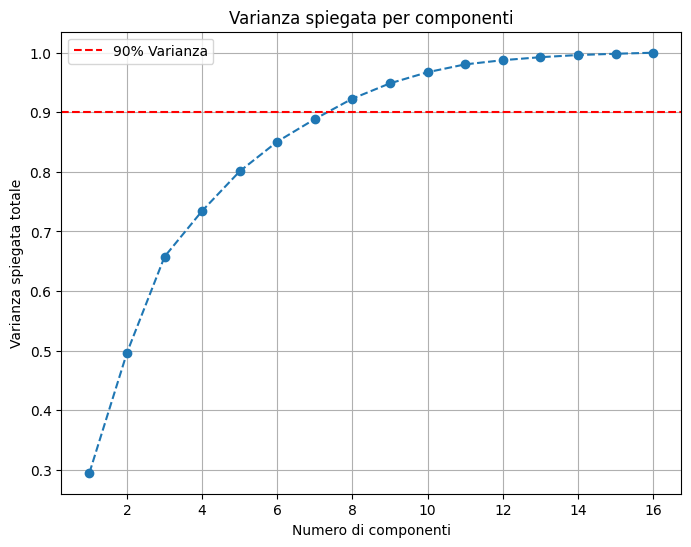

Numero ottimale di componenti: 8
Dataset PCA salvato in: ../data/processed/pendigits_pca.csv


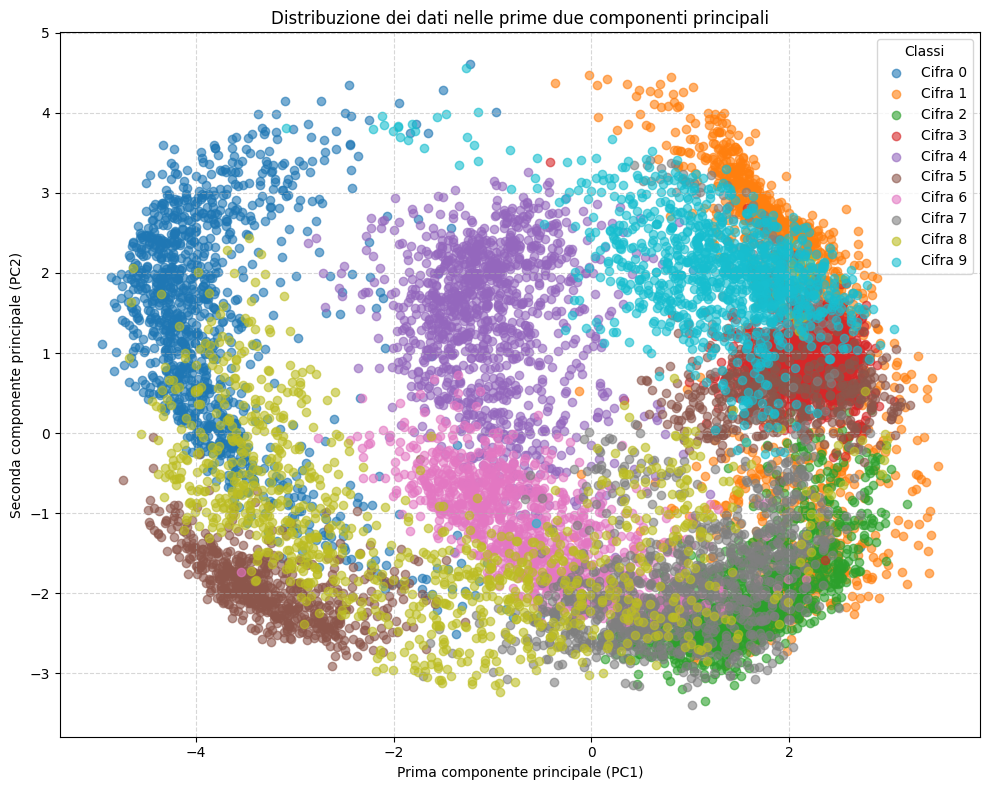

In [33]:
#funzione per scaricare il dataset
def get_data(name: str):
    
    #recupero il dataset dal modulo sklearn
    pendigits = fetch_openml(name = "pendigits", version=1, as_frame=True)
    
    #creo un dataframe con i dati e le etichette
    X = pendigits.data
    y = pendigits.target

    #estraggo il numero di colonne del dataframe
    n_col = X.shape[1]

    #modifico il nome delle classi
    X.columns = [
    f"x{index}" if i % 2 == 0 else f"y{index}"
    for i in range(n_col)
    for index in [i // 2]
    ]

    #unisco i dati e le etichette in un unico dataframe
    df = X.copy()
    df['target'] = y
    
    #visualizziamo le prime 5 righe del dataset
    print(df.head())
    
    #salvo il dataframe in formato csv
    df.to_csv("../data/raw/pendigits.csv", index = False)
    
#funzione per visualizzare un campione dei dati estratti
def visualize_raw_data():
    #recupero il dataset
    ds = pd.read_csv("../data/raw/pendigits.csv")

    #estraggo le features e i targets
    X = ds.drop(columns="target")
    y = ds["target"]

    #seleziono le prime 5 istanze
    indices = range(5)

    #imposto i sottografi
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle('Visualizzazione delle prime 5 cifre', fontsize=16)

    for i, index in enumerate(indices):
        instance = X.iloc[index].values
        digit = y.iloc[index]

        #estraggo le coordinate dei punti che formano la cifra
        #le feature pari rappresentano le x dei punti, ordinate in sequenza
        x_coords = instance[::2]

        #le feature dispari rappresentano le y dei punti, ordinate in sequenza
        y_coords = instance[1::2]

        #tramite un line plot disegno i punti che formano la cifra
        axes[i].plot(x_coords, y_coords, marker='o', color='blue', markersize=5)
        axes[i].set_title(f'Cifra: {digit}', fontsize=12)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

#funzione per effettuare il preprocessamento del dataset
def preprocessing_pipeline():

    #apriamo il dataset che abbiamo creato 
    df = pd.read_csv("../data/raw/pendigits.csv")
    y = df['target']
    X = df.drop(columns=["target"])
    
    #verifichiamo la presenza di valori mancanti
    missing_counts = X.isnull().sum()
    if not missing_counts.any():
        print("Il dataset non contiene valori mancanti") 
    else: 
        print("Il dataset contiene valori mancanti")
    
    #standardizziamo il dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    #ricreiamo il dataframe con le feature standardizzate
    df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    df_scaled['target'] = y.reset_index(drop=True)

    #salviamo il dataset standardizzato in formato csv
    output_path = "../data/processed/pendigits_standardized.csv"
    df_scaled.to_csv(output_path, index=False)
    
    #applichiamo la pca per effettuare una feature extraction
    pca = PCA()
    X_pca = pca.fit(X_scaled)

    #determiniamo il numero di componenti ottimale con l'elbow method
    explained_variance = np.cumsum(X_pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    plt.title('Varianza spiegata per componenti')
    plt.xlabel('Numero di componenti')
    plt.ylabel('Varianza spiegata totale')
    plt.axhline(y=0.9, color='r', linestyle='--', label='90% Varianza')
    plt.legend()
    plt.grid()
    plt.show()

    #selezioniamo il numero di componenti che spiegano ~90% della varianza
    optimal_components = np.argmax(explained_variance >= 0.9) + 1
    print(f"Numero ottimale di componenti: {optimal_components}")
    pca = PCA(n_components=optimal_components)
    X_pca_optimal = pca.fit_transform(X_scaled)

    #ricreiamo il dataframe con le feature estratte
    pca_columns = [f"PC{i+1}" for i in range(optimal_components)]
    df_pca = pd.DataFrame(X_pca_optimal, columns=pca_columns)
    df_pca['target'] = y.reset_index(drop=True)

    #salviamo il dataset trasformato in formato csv
    output_path = "../data/processed/pendigits_pca.csv"
    df_pca.to_csv(output_path, index=False)
    print(f"Dataset PCA salvato in: {output_path}")

#funzione per visualizzare la distribuzione delle classi dopo la feature extraction
def visualize_pca_2d():
    #carichiamo il dataset PCA salvato
    df_pca = pd.read_csv("../data/processed/pendigits_pca.csv")

    #visualizziamo le prime due componenti principali, ordinando le classi
    plt.figure(figsize=(10, 8))
    for label in sorted(df_pca['target'].unique()):
        subset = df_pca[df_pca['target'] == label]
        plt.scatter(
            subset['PC1'],
            subset['PC2'],
            label=f'Cifra {label}',
            alpha=0.6
        )
    plt.title('Distribuzione dei dati nelle prime due componenti principali')
    plt.xlabel('Prima componente principale (PC1)')
    plt.ylabel('Seconda componente principale (PC2)')
    plt.legend(title="Classi")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    

get_data("pendigits")
visualize_raw_data()
preprocessing_pipeline()
visualize_pca_2d()

Visualizziamo un item del del dataset

Checking for missing values...
No missing values found.
Standardizing the dataset...
Applying PCA...


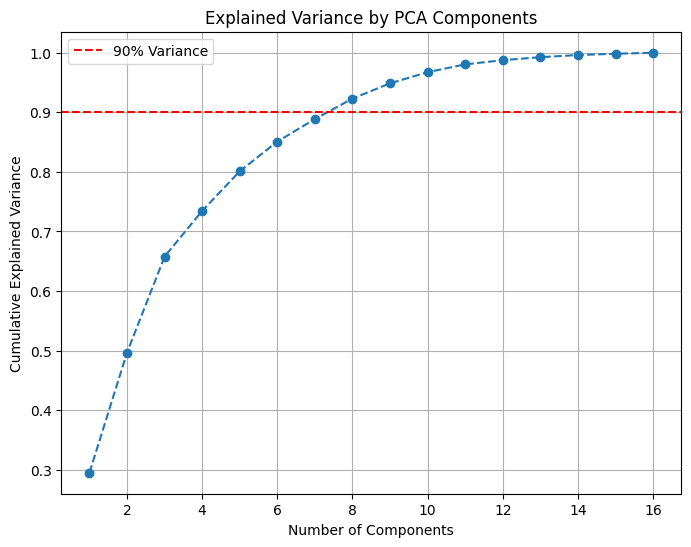

Optimal number of components: 8


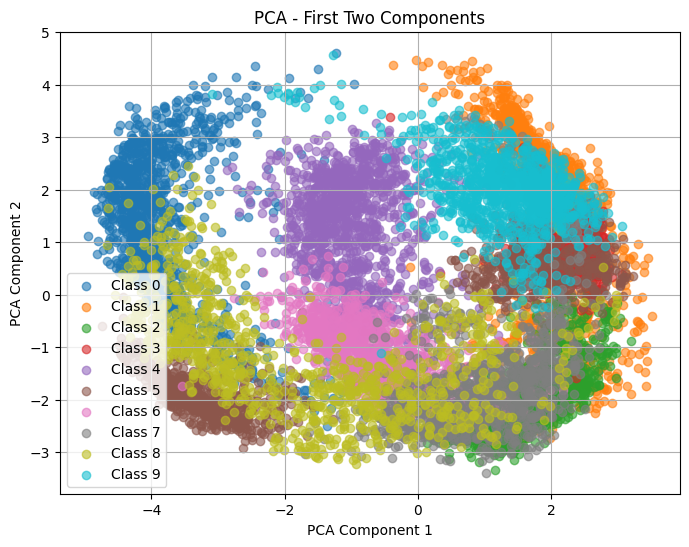

Preprocessing complete. Data saved to 'processed_pendigits.csv'.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_openml

# Step 1: Load the dataset
data = fetch_openml(name='pendigits', version=1)
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')



# Step 4: Apply PCA to reduce dimensionality
print("Applying PCA...")
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Determine optimal number of components using the elbow method
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.legend()
plt.grid()
plt.show()

# Select number of components that explain ~90% variance
optimal_components = np.argmax(explained_variance >= 0.9) + 1
print(f"Optimal number of components: {optimal_components}")
pca = PCA(n_components=optimal_components)
X_pca_optimal = pca.fit_transform(X_scaled)

# Step 5: Visualize the first two PCA components
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(
        X_pca_optimal[y == label, 0],
        X_pca_optimal[y == label, 1],
        label=f'Class {label}',
        alpha=0.6
    )
plt.title('PCA - First Two Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

# Save the processed data
processed_data = pd.DataFrame(X_pca_optimal, columns=[f'PC{i+1}' for i in range(optimal_components)])
processed_data['target'] = y.reset_index(drop=True)
processed_data.to_csv('processed_pendigits.csv', index=False)
print("Preprocessing complete. Data saved to 'processed_pendigits.csv'.")


1